# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 140000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (140000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(118907, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.93357142857143

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

Observation(s):

1. I have keep only those values whose HelpfulnessNumerator <= HelpfulnessDenominator.

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(118905, 10)


1    99869
0    19036
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_118904 = final['Text'].values[118904]
print(sent_118904)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.
I love chai tea and this is definitely reminiscent of that. It's got a wonderful aroma and tastes good hot or cold. I'm definitely buying it again. It also reminds me of special home-made tea I had at a NYC Indian restaurant which was fabulous. Excellent tea. Well worth the price!
Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.strongly recommend


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

Purchased this product at a local store in NY and my kids and i love it. Its a quick easy meal. You can put in a toaster oven on toast for 6 min. and its ready to eat.<br />strongly recommend


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Get the movie or sound track and sing along with Carol King. This is great stuff, my whole extended family knows these songs by heart. Quality kids storytelling and music.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

Purchased this product at a local store in NY and my kids and i love it Its a quick easy meal You can put in a toaster oven on toast for 6 min and its ready to eat br strongly recommend


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

Observation(s):

1. Here we are having set of stopwords.
2. Here so many unused word in the stopwords.
3. stopwords are words which contain a dictionary of unused words.
4. If we are removing stopwordsthen our Bag of Words is much smaller and meaningful vector.

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [01:21<00:00, 1462.45it/s]


In [23]:
preprocessed_reviews[118904]

'purchased product local store ny kids love quick easy meal put toaster oven toast min ready eat strongly recommend'

In [24]:
#adding a column of CleanedText which displays the data after pre-processing of the review
final['CleanedText']=preprocessed_reviews
final['CleanedText']=final['CleanedText']
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (118905, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138687,150505,0006641040,A2PTSM496CF40Z,"Jason A. Teeple ""Nobody made a greater mistak...",1,1,1,1210809600,A classic,Get the movie or sound track and sing along wi...,get movie sound track sing along carol king gr...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138705,150523,0006641040,A2P4F2UO0UMP8C,"Elizabeth A. Curry ""Lovely Librarian""",0,0,1,1096675200,MMMM chicken soup....,Summary: A young boy describes the usefulness...,summary young boy describes usefulness chicken...


Observation(s):

1. Here processed review can be seen in the CleanedText Column.
2. We will use it for future observation.
3. we are having 118905 matrix of features.

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
# printing some random reviews
sent_0 = final['Summary'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Summary'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Summary'].values[1500]
print(sent_1500)
print("="*50)

sent_118904 = final['Summary'].values[118904]
print(sent_118904)
print("="*50)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [26]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_118904 = re.sub(r"http\S+", "", sent_118904)

print(sent_0)

A classic


In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_118904, 'lxml')
text = soup.get_text()
print(text)

A classic
Wonderfully soothing tea
Awesome underlooked seasoning!
DELICIOUS


In [28]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [29]:
sent_118904 = decontracted(sent_118904)
print(sent_118904)
print("="*50)

DELICIOUS


In [30]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

A classic


In [31]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_118904 = re.sub('[^A-Za-z0-9]+', ' ', sent_118904)
print(sent_118904)

DELICIOUS


In [32]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [33]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_Summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 118905/118905 [00:54<00:00, 2197.26it/s]


In [34]:
preprocessed_Summary = [118904]
print (preprocessed_Summary)

[118904]


# Time Based Splitting

In [247]:
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

# Randomly selecting 20K datapoints

# We will collect different 20K rows without repetition from time_sorted_data dataframe
final_20 = time_sorted_data.take(np.random.permutation(len(final))[:100000])
print(final_20.shape)
final_20.head(3)

(100000, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
6131,6642,B001LG945O,A6VSWJVTWEOII,Tabitha,0,0,0,1245888000,"Too sweet, too expensive, too much packaging","Yeah it's gluten free and whatever, but unless...",yeah gluten free whatever unless really big is...
60230,65447,B001EQ55ZO,AVOCNUFOXUCA6,Brian A. Schar,0,0,1,1214956800,Decent nuts,"It's very difficult to review a food item, bec...",difficult review food item taste tremendously ...
137809,149563,B000E8WIAS,A2C720W4GKCKVU,Bifocaled Mom,0,0,1,1318377600,Scrumptious!,Sweet Leaf Vanilla Creme Flavored Liquid Stevi...,sweet leaf vanilla creme flavored liquid stevi...


Observation(s):
1. Time based splitting is better than random splitting.
2. In time based splitting we sort our data in ascending order.
3. In TIme based splitting we get better accuracy than random splitting.

In [249]:
# sample dataset 
final_20['Score'].value_counts()

1    83933
0    16067
Name: Score, dtype: int64

In [250]:
# Original dataset
final['Score'].value_counts()

1    99869
0    19036
Name: Score, dtype: int64

In [251]:
# Ratio of positive reviews to negative reviews in Sample Dataset
len(final_20[final_20['Score'] == 1])/len(final_20[final_20['Score'] == 0])

5.223937262712392

In [252]:
# Ratio of positive reviews to negative reviews in Original Dataset
len(final[final['Score'] == 1])/len(final[final['Score'] == 0])

5.246322756881698

In [253]:
# final_20 datapoints which will use to train model
X = final_20['CleanedText'].values
print("shape of X:", X.shape)

shape of X: (100000,)


In [254]:
# class label
y = final_20['Score'].values
print("shape of y:", y.shape)

shape of y: (100000,)


In [255]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# Splitting the data set into training set and test set:
from sklearn.model_selection import train_test_split

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)
X_train, X_cv, Y_train, Y_cv = train_test_split(X_train, Y_train, test_size=0.33)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape, X_cv.shape, Y_cv.shape)

(53600,) (53600,) (20000,) (20000,) (26400,) (26400,)


Observation(s):
    
1. I have split the dataset into training set and testing set.
2. Here 80% of the data used to train the model and 20% of the data used to test its performance of the test set.
3. Here i have 53600 points to train the model and 20000 points to test its performance on the test set.

# [4] Featurization

## [4.1] BAG OF WORDS

In [256]:
#BoW
#https://www.kaggle.com/rochachan/part-1-for-beginners-bag-of-words
from sklearn.feature_extraction.text import CountVectorizer    #in scikit-learn
count_vect = CountVectorizer(min_df = 20, max_features=500).fit(X_train) # Here I am fitting my CountVectorizer function  into X_train and Then transform into X_train and X_test. 
# we also use fit_transform method for training set. I am doind it for auc
# min_df = 20;min_df = 20, which will remove any words from our vocabulary that appear in fewer than five documents.
# https://towardsdatascience.com/scikit-learn-for-text-analysis-of-amazon-fine-food-reviews-ea3b232c2c1b
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, Y_train.shape)
print(X_cv_bow.shape, Y_cv.shape)
print(X_test_bow.shape, Y_test.shape)
print("="*100)

print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_bow))
print("the shape of out text BOW vectorizer : ",X_train_bow.get_shape())
print("the number of unique words :", X_train_bow.get_shape()[1])

After vectorizations
(53600, 500) (53600,)
(26400, 500) (26400,)
(20000, 500) (20000,)
some feature names  ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almost', 'also']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (53600, 500)
the number of unique words : 500


## [4.2] Bi-Grams and n-Grams.

In [257]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=20, max_features=500).fit(X_train)
X_train_bow = count_vect.transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_bow.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (53600, 500)
the number of unique words including both unigrams and bigrams  500


## [4.3] TF-IDF

In [258]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(min_df=50, max_features=500).fit(X_train)
X_train_tf_idf = tf_idf_vect.transform(X_train)
X_cv_tf_idf = tf_idf_vect.transform(X_cv)
X_test_tf_idf = tf_idf_vect.transform(X_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer :",type(X_train_tf_idf))
print("the shape of out text TFIDF vectorizer : ",X_train_tf_idf.get_shape())
print("the number of unique words :", X_train_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'adding', 'aftertaste', 'ago', 'almost', 'also']
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (53600, 500)
the number of unique words : 500


In [259]:
print("the number of unique words :", X_test_tf_idf.get_shape()[1])

the number of unique words : 500


## [4.4] Word2Vec

## Preparing Reviews for gensim model

In [260]:
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

## Training w2v model

In [261]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [262]:
# Train our own Word2Vec model using our own train text corpus 
# min_count = 5 considers only words that occured atleast 5 times
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
print(w2v_model.wv.most_similar('great'))
print('='*50)
print(w2v_model.wv.most_similar('worst'))
print('='*70)

[('good', 0.8559093475341797), ('fantastic', 0.8273736834526062), ('awesome', 0.8221958875656128), ('excellent', 0.7626374959945679), ('wonderful', 0.7621761560440063), ('terrific', 0.7618666291236877), ('decent', 0.7409958839416504), ('perfect', 0.7141178846359253), ('amazing', 0.6950316429138184), ('incredible', 0.6404983401298523)]
[('greatest', 0.7347432374954224), ('best', 0.7316804528236389), ('tastiest', 0.6811757683753967), ('coolest', 0.6430554389953613), ('nicest', 0.6370964050292969), ('superior', 0.635431170463562), ('closest', 0.634228527545929), ('awful', 0.622591495513916), ('nastiest', 0.6075632572174072), ('disgusting', 0.6071618795394897)]


In [263]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  14026
sample words  ['cake', 'not', 'taste', 'like', 'tastes', 'bread', 'diagnosed', 'allergic', 'wheat', 'used', 'no', 'substitute', 'reason', 'give', 'two', 'stars', 'tasted', 'worst', 'times', 'bit', 'going', 'try', 'devil', 'food', 'flavor', 'good', 'buy', 'would', 'recommend', 'product', 'clumpy', 'throughout', 'hard', 'black', 'bits', 'burned', 'stuff', 'throw', 'away', 'one', 'every', 'three', 'pods', 'dog', 'resist', 'treats', 'get', 'anything', 'conditioner', 'light']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

## Algorithm: Avg W2V

#### [4.4.1.1] Avg W2v

In [264]:
from tqdm import tqdm
import numpy as np

### Converting Train data text

In [265]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 53600/53600 [02:57<00:00, 302.71it/s]


(53600, 50)
[ 0.50921563  0.08616359 -0.52519681  0.62487905 -0.49488168 -0.56914643
  0.05532656 -0.51799232  0.70881196 -0.99702889  0.17656621 -0.36344314
  0.25277134 -0.09066901  0.75800054 -0.07293516  0.65469091 -0.12993023
  0.67951068 -0.14788846  0.42588918  0.44846206  0.25538353  0.23573493
  0.75018836  0.99054011  0.60567264 -0.45630299  0.32668686 -0.15478816
  0.57913747 -0.60282498 -0.24407982  0.6703399   0.30885423  0.95806704
 -0.22905129 -0.56245237 -0.34985589 -0.61417663  0.04456593  0.05926855
  0.4937169  -0.58082126  0.94988301  0.08992208  0.73733924  0.08883821
  1.31207994  0.26787119]


### Converting CV data text

In [266]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [267]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|███████████████████████████████████████████████████████████████████████████| 26400/26400 [01:29<00:00, 295.20it/s]


(26400, 50)
[ 0.71790174 -0.43327188  0.07555832 -0.23147007 -0.31689198 -0.19950872
 -0.07046931 -0.69972454  0.37408773 -0.23514075 -0.31338938 -0.03579563
 -0.32775603  0.05352105 -0.13607174 -0.08221792  0.57489426 -0.07199173
  0.19653662 -0.14226625  0.53299904  0.20110033  0.20021467  0.02265405
  0.08771213  0.61275764 -0.66293458 -0.14049715  0.26338989  0.19971093
 -0.08768949 -0.14393984  0.13507003  0.37471972 -0.01062414 -0.20967916
  0.13145184  0.04987234 -0.56559223  0.22224921  0.31820142  0.78195935
  0.34732036 -0.45899912 -0.12145059 -0.33007762  0.23481906  0.14535622
  0.56174705  0.54214181]


### Converting Test data text

In [268]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [269]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [01:08<00:00, 290.35it/s]


(20000, 50)
[ 1.00467693  0.44911633  0.12723565  0.24994676 -0.57603855 -0.86281952
  0.50666995 -0.30806995  0.37834648 -0.39242088 -0.48206788  0.59949393
 -1.10845918  0.02708984  1.26289449 -0.24129535  0.37818474  0.3286029
 -0.64165945 -0.36569642  0.06982268 -0.00364905  0.73947718 -0.59167017
  0.63272446  1.04825906 -0.06925846 -1.06175748  0.41434489  0.12585433
  0.46790234  0.43687444 -0.4877161   0.45179773 -0.28324841  0.71314758
 -0.40868085 -0.44758167 -1.19855675  0.29168807 -0.13872848 -0.13405484
 -0.09580259 -0.69461439  0.30889027 -0.35771474  0.28469306 -0.17192752
  0.67443395 -0.31574235]


#### [4.4.1.2] TFIDF weighted W2v

In [270]:
from tqdm import tqdm
import numpy as np

In [271]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

### Converting Train data text

In [272]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)
print(tfidf_sent_vectors_train.shape)
print(tfidf_sent_vectors_train[0])

100%|██████████████████████████████████████████████████████████████████████████| 53600/53600 [1:06:09<00:00, 19.31it/s]


(53600, 50)
[ 0.32538234  0.04451313 -0.52052436  0.16696139 -0.72224919 -1.02395272
 -0.33875732 -0.93999294  1.00416279 -1.67815558 -0.0330781  -0.7558577
  0.50767296  0.08992517  0.52694986 -0.3631181   0.92896667 -0.35892875
  2.17110588 -0.56195711  0.41072607  0.21430586 -0.2877948   0.70023447
  1.05406351  0.0449216   1.08792934 -0.34630581  0.29657297 -0.0792023
  0.6540284  -0.87903254 -0.29820252  1.07259525  0.65989334  0.86701716
 -0.20630426 -0.70081748 -0.12518285 -0.19916694  0.44528747 -0.69900625
  0.58116709 -0.63612979  1.11895559 -0.64655028  0.43298164  0.04707812
  1.47943198  0.20319191]


In [273]:
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

53600
50


### Converting CV data text

In [274]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())

In [275]:
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
tfidf_sent_vectors_cv = np.array(tfidf_sent_vectors_cv)
print(tfidf_sent_vectors_cv.shape)
print(tfidf_sent_vectors_cv[0])

100%|████████████████████████████████████████████████████████████████████████████| 26400/26400 [31:09<00:00, 14.12it/s]


(26400, 50)
[ 0.57887553 -0.61370733  0.21720629 -0.33264446 -0.2299672  -0.08334385
 -0.11927825 -0.71606834  0.19543791 -0.19849258 -0.32366117 -0.00074069
 -0.3866224   0.04600921 -0.31675174 -0.045713    0.65308026 -0.05021995
  0.16128468 -0.12626643  0.60438785  0.31568499  0.12682485  0.07875576
  0.06322076  0.4650189  -0.68296322 -0.06918883  0.29625767  0.18330507
 -0.06853484 -0.12224581  0.14392999  0.37393584  0.00859917 -0.15576499
  0.18378238  0.17159123 -0.58159602  0.35072747  0.35979189  0.68219393
  0.40656985 -0.39539267 -0.32029478 -0.57226002  0.09379112  0.24224855
  0.50245827  0.56320243]


### Converting Test data text

In [276]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [277]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_fealist_of_sentance_traint.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
print(tfidf_sent_vectors_test.shape)
print(tfidf_sent_vectors_test[0])

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [23:04<00:00, 14.45it/s]


(20000, 50)
[ 0.9696722   0.34017867  0.12388925  0.35855363 -0.5360398  -0.75358357
  0.51329159 -0.29753189  0.35864757 -0.54379692 -0.34932571  0.63514163
 -1.06559764 -0.00666865  1.28659113 -0.24276256  0.34320518  0.17460498
 -0.60380552 -0.3508687   0.01648846 -0.01547924  0.71053313 -0.65055555
  0.64133025  0.98538957 -0.03700519 -0.94100038  0.40292541  0.05911085
  0.44575342  0.44354654 -0.38592766  0.54408547 -0.27767465  0.69496805
 -0.41347501 -0.3645705  -1.16889611  0.30770974 -0.187172   -0.22865479
 -0.07960646 -0.7820541   0.19823511 -0.27871409  0.22764242 -0.29176374
  0.59282477 -0.28480187]


# [5] Assignment 7: SVM

<ol>
    <li><strong>Apply SVM on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Procedure</strong>
        <ul>
    <li>You need to work with 2 versions of SVM
        <ul><li>Linear kernel</li>
            <li>RBF kernel</li></ul>
    <li>When you are working with linear kernel, use SGDClassifier’ with hinge loss because it is computationally less expensive.</li>
    <li>When you are working with ‘SGDClassifier’ with hinge loss and trying to find the AUC
        score, you would have to use <a href='https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html'>CalibratedClassifierCV</a></li>
    <li>Similarly, like kdtree of knn, when you are working with RBF kernel it's better to reduce
the number of dimensions. You can put min_df = 10, max_features = 500 and consider a sample size of 40k points.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best alpha in range [10^-4 to 10^4], and the best penalty among 'l1', 'l2')</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>When you are working on the linear kernel with BOW or TFIDF please print the top 10 best
features for each of the positive and negative classes.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

### Applying Linear SVM with L1 regularization on BOW,<font color='red'> SET 1</font>

In [278]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bow_standardized = sc.fit_transform(X_train_bow)
X_test_bow_standardized = sc.transform(X_test_bow)
X_cv_bow_standardized = sc.transform(X_cv_bow)

In [362]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'alpha': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
param_grid = {'alpha': Alpha}

#Using GridSearchCV
model = GridSearchCV(SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_bow_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_bow_standardized, Y_cv))


optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9055447048766688
The optimal value of alpha is :  0.0001


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

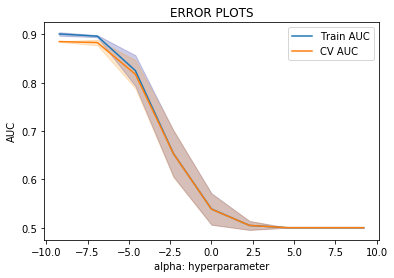

In [363]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in alpha:

    SGD = SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced", alpha = i)
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'alpha': Alpha}
    clf = GridSearchCV(SGD, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_bow_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(alpha), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(alpha), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

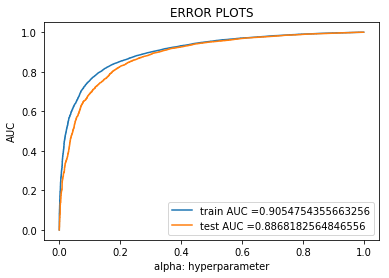

Train confusion matrix
[[ 3266  5375]
 [ 1233 43726]]
Test confusion matrix
[[ 1226  1949]
 [  493 16332]]
Test AUC is: 0.8868182564846556


In [364]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# https://github.com/scikit-learn/scikit-learn/issues/7278

SGD = SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced", alpha = 0.0001) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
calibrated_clf = CalibratedClassifierCV(SGD, cv=5, method='sigmoid')
calibrated_clf.fit(X_train_bow_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, calibrated_clf.predict_proba(X_train_bow_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, calibrated_clf.predict_proba(X_test_bow_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, calibrated_clf.predict(X_train_bow_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, calibrated_clf.predict(X_test_bow_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
bow_L1_auc = roc_auc_score(Y_test, calibrated_clf.predict_proba(X_test_bow_standardized)[:,1])
print("Test AUC is:", bow_L1_auc)

# Testing with Test data

In [365]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== SGD with alpha = optimal_alpha ===============================================
# instantiate learning model alpha = optimal_alpha

SGD_optimal = SGDClassifier(alpha=optimal_alpha)

# fitting the model
SGD_optimal.fit(X_train_bow_standardized, Y_train)

# predict the response
Y_pred = SGD_optimal.predict(X_test_bow_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the SGDClassifier classifier for alpha = %.4f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_L1_grid_C = optimal_alpha
bow_L1_grid_train_acc = model.score(X_test_bow_standardized, Y_test)*100
bow_L1_grid_test_acc = acc


The Test Accuracy of the SGDClassifier classifier for alpha = 0.0001 is 85.210000%


Observation(s):
    
1. The Test Accuracy of the SGDClassifier classifier for alpha = 0.0001 is 85.210000%.

# Confusion Matrix of Training Set Of BOW Model

In [366]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, calibrated_clf.predict(X_train_bow_standardized))
cm

array([[ 3266,  5375],
       [ 1233, 43726]], dtype=int64)

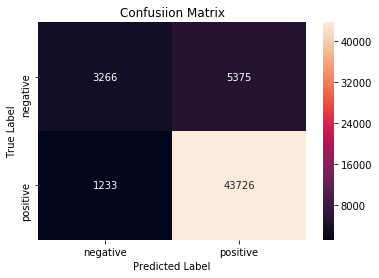

In [367]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of BOW Model.
1. As we have seen on confusion matrix, we have 43726 + 3266 = 46992 correct prediction on training set.
2. Acccuracy of 46992 correct prediction on training set is 87.676%.

# Confusion Matrix For Test Set Of BOW Model

In [368]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, calibrated_clf.predict(X_test_bow_standardized)))
cm

array([[ 1226,  1949],
       [  493, 16332]], dtype=int64)

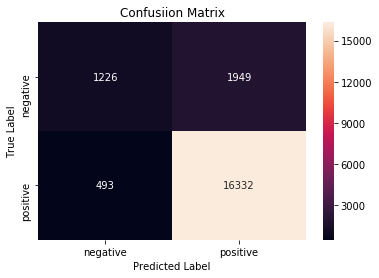

In [369]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of BOW Model.
2. As we have seen on confusion matrix, we have 16332 + 1226 = 17540 correct prediction on test set.
2. we have 17540 correct prediction on test set.

### Applying Linear SVM with L2 regularization on BOW,<font color='red'> SET 1</font>

# GridSearchCV Implementation

In [287]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'alpha': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
param_grid = {'alpha': Alpha}

#Using GridSearchCV
model = GridSearchCV(SGDClassifier(penalty='l2', loss = "hinge",  class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_bow_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_bow_standardized, Y_cv))


optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9138940455236135
The optimal value of alpha is :  0.1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

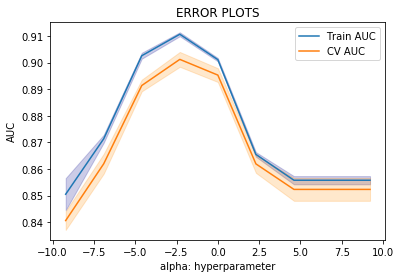

In [288]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in alpha:

    SGD = SGDClassifier(penalty='l2', loss = "hinge",  class_weight = "balanced", alpha = i)
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'alpha': Alpha}
    clf = GridSearchCV(SGD, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_bow_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(alpha), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(alpha), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

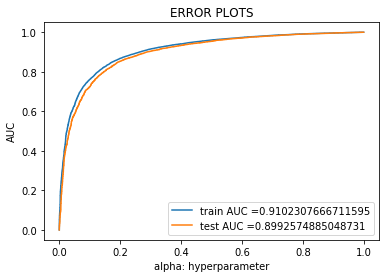

Train confusion matrix
[[ 3824  4817]
 [ 1426 43533]]
Test confusion matrix
[[ 1375  1800]
 [  555 16270]]
Test AUC is: 0.8992574885048731


In [289]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# https://github.com/scikit-learn/scikit-learn/issues/7278

SGD = SGDClassifier(penalty='l2', loss = "hinge", class_weight = "balanced", alpha = 0.1) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
calibrated_clf = CalibratedClassifierCV(SGD, cv=5, method='sigmoid')
calibrated_clf.fit(X_train_bow_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, calibrated_clf.predict_proba(X_train_bow_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, calibrated_clf.predict_proba(X_test_bow_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, calibrated_clf.predict(X_train_bow_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, calibrated_clf.predict(X_test_bow_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
bow_L2_auc = roc_auc_score(Y_test, calibrated_clf.predict_proba(X_test_bow_standardized)[:,1])
print("Test AUC is:", bow_L2_auc)

In [290]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== SGD with alpha = optimal_alpha ===============================================
# instantiate learning model alpha = optimal_alpha

SGD_optimal = SGDClassifier(alpha=optimal_alpha)

# fitting the model
SGD_optimal.fit(X_train_bow_standardized, Y_train)

# predict the response
Y_pred = SGD_optimal.predict(X_test_bow_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the SGDClassifier classifier for alpha = %.3f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
bow_L2_grid_C = optimal_alpha
bow_L2_grid_train_acc = model.score(X_test_bow_standardized, Y_test)*100
bow_L2_grid_test_acc = acc


The Test Accuracy of the SGDClassifier classifier for alpha = 0.100 is 88.810000%


Observation(s):
    
1. The Test Accuracy of the SGDClassifier classifier for alpha = 0.100 is 88.810000%.

# Confusion Matrix of Training Set Of BOW Model

In [291]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, calibrated_clf.predict(X_train_bow_standardized)))
cm

array([[ 3824,  4817],
       [ 1426, 43533]], dtype=int64)

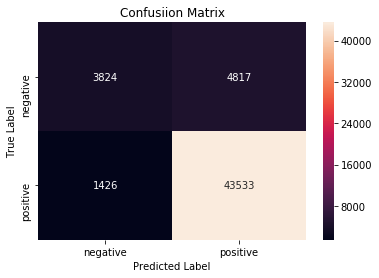

In [292]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of BOW Model.
1. As we have seen on confusion matrix, we have 43533 + 3824 = 47357 correct prediction on training set.
2. Acccuracy of 47357 correct prediction on training set is 88.352%.

# Confusion Matrix For Test Set Of BOW Model

In [293]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, calibrated_clf.predict(X_test_bow_standardized)))
cm

array([[ 1375,  1800],
       [  555, 16270]], dtype=int64)

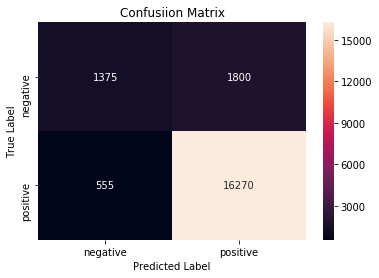

In [294]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of BOW Model.
2. As we have seen on confusion matrix, we have 16270 + 1375 = 17645 correct prediction on test set.
2. we have 17645 correct prediction on test set.

### Feature Importance on BOW,<font color='red'> SET 1</font>

#### Top 10 important features of positive class from<font color='red'> SET 1</font>

In [295]:
# Now we can find log probabilities of different features for 'positive' classes
class_features = SGD_optimal.coef_   # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
# row_0 is for 'positive' class
positive_features = class_features[0]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'positive_features' in descending order using argsort() function
sorted_positive_features = np.argsort(positive_features)[::-1]
    
print("\n\nTop 10 Important Features and their log probabilities For Positive Class :\n\n")
for i in list(sorted_positive_features[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))



Top 10 Important Features and their log probabilities For Positive Class :


great	 -->	0.267899  
good	 -->	0.219586  
love	 -->	0.191965  
best	 -->	0.185600  
delicious	 -->	0.156851  
loves	 -->	0.144732  
perfect	 -->	0.118321  
excellent	 -->	0.118035  
nice	 -->	0.105820  
wonderful	 -->	0.104846  


#### Top 10 important features of negative class from<font color='red'> SET 1</font>

In [296]:
# Now we can find log probabilities of different features for 'negative' classes
class_features = SGD_optimal.coef_     # https://stackoverflow.com/questions/29867367/sklearn-multinomial-nb-most-informative-features
                                               # coef_ value is proportional to feature_log_prob_
                                               # It is like feature importance. This will give us festure importance
#  row_0 is for 'negative' class
negative_features = class_features[0]

# Getting all feature names
feature_names = count_vect.get_feature_names()

# Sorting 'negative_features' in descending order using argsort() function
sorted_negative_features = np.argsort(negative_features)[::-1]

print("Top 10 Important Features and their log probabilities For Negative Class :\n\n")
for i in list(sorted_negative_features[:-10:-1]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))

Top 10 Important Features and their log probabilities For Negative Class :


not	 -->	-0.151549  
disappointed	 -->	-0.119418  
money	 -->	-0.116159  
not good	 -->	-0.113673  
bad	 -->	-0.100989  
would not	 -->	-0.097152  
thought	 -->	-0.087542  
away	 -->	-0.082647  
maybe	 -->	-0.075781  


### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

### Applying Linear SVM with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [297]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_tf_idf_standardized = sc.fit_transform(X_train_tf_idf)
X_cv_tf_idf_standardized = sc.fit_transform(X_cv_tf_idf)
X_test_tf_idf_standardized = sc.transform(X_test_tf_idf)

# GridSearchCV Implementation

In [298]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'alpha': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
param_grid = {'alpha': Alpha}

#Using GridSearchCV
model = GridSearchCV(SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_tf_idf_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_tf_idf_standardized, Y_cv))


optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9064448444427494
The optimal value of alpha is :  0.001


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

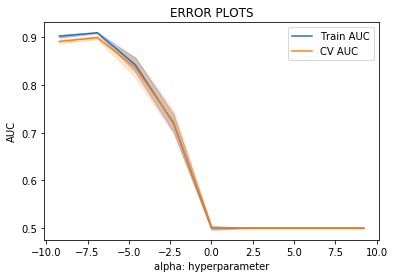

In [299]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in alpha:

    SGD = SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced", alpha = i)
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'alpha': Alpha}
    clf = GridSearchCV(SGD, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_tf_idf_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(alpha), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(alpha), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

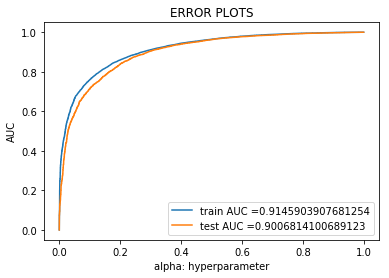

Train confusion matrix
[[ 4024  4617]
 [ 1308 43651]]
Test confusion matrix
[[ 1461  1714]
 [  505 16320]]
Test AUC is: 0.9006814100689123


In [316]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# https://github.com/scikit-learn/scikit-learn/issues/7278

SGD = SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced", alpha = 0.001) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
calibrated_clf = CalibratedClassifierCV(SGD, cv=5, method='sigmoid')
calibrated_clf.fit(X_train_tf_idf_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, calibrated_clf.predict_proba(X_train_tf_idf_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, calibrated_clf.predict_proba(X_test_tf_idf_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, calibrated_clf.predict(X_train_tf_idf_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, calibrated_clf.predict(X_test_tf_idf_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_L1_auc  = roc_auc_score(Y_test, calibrated_clf.predict_proba(X_test_tf_idf_standardized)[:,1])
print("Test AUC is:", tfidf_L1_auc)

In [318]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== SGD with alpha = optimal_alpha ===============================================
# instantiate learning model alpha = optimal_alpha

SGD_optimal = SGDClassifier(alpha=optimal_alpha)

# fitting the model
SGD_optimal.fit(X_train_tf_idf_standardized, Y_train)

# predict the response
Y_pred = SGD_optimal.predict(X_test_tf_idf_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Stochastic Gradient Descent classifier for alpha = %.4f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_L1_grid_C = optimal_alpha
tfidf_L1_grid_train_acc = model.score(X_test_tf_idf_standardized, Y_test)*100
tfidf_L1_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 88.845000%


Observation(s):

1. The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 88.845000%.

# Confusion Matrix of Training Set Of TFIDF Model

In [319]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, calibrated_clf.predict(X_train_tf_idf_standardized)))
cm

array([[ 4024,  4617],
       [ 1308, 43651]], dtype=int64)

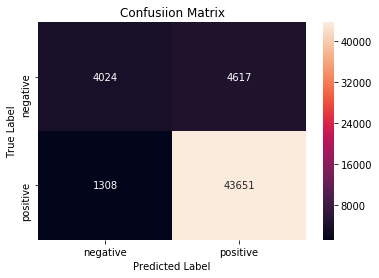

In [320]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF Model.
1. As we have seen on confusion matrix, we have 43651 + 4024 = 47675 correct prediction on training set.
2. Acccuracy of 47675 correct prediction on training set is 88.945%.

# Confusion Matrix of Test Set Of TFIDF Model

In [321]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, calibrated_clf.predict(X_test_tf_idf_standardized)))
cm

array([[ 1461,  1714],
       [  505, 16320]], dtype=int64)

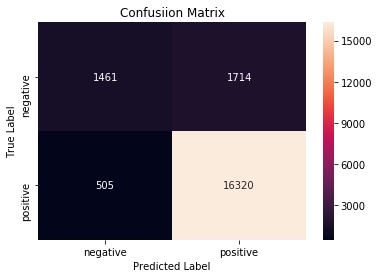

In [322]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF Model.
2. As we have seen on confusion matrix, we have 16320 + 1461 = 17781 correct prediction on test set.
2. We have 17781 correct prediction on test set.

### Applying Linear SVM with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [306]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'alpha': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
param_grid = {'alpha': Alpha}

#Using GridSearchCV
model = GridSearchCV(SGDClassifier(penalty='l2', loss = "hinge", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_tf_idf_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_tf_idf_standardized, Y_cv))


optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9163596449737312
The optimal value of alpha is :  0.1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

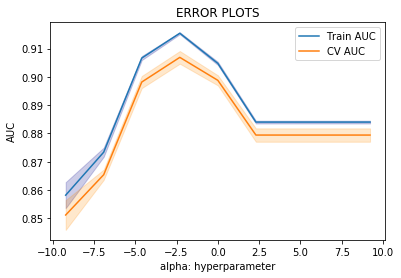

In [307]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in alpha:

    SGD = SGDClassifier(penalty='l2', loss = "hinge", class_weight = "balanced", alpha = i)
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'alpha': Alpha}
    clf = GridSearchCV(SGD, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_tf_idf_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(alpha), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(alpha), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

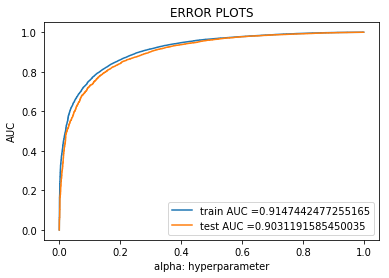

Train confusion matrix
[[ 4389  4252]
 [ 1569 43390]]
Test confusion matrix
[[ 1555  1620]
 [  613 16212]]
Test AUC is: 0.9031191585450035


In [308]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# https://github.com/scikit-learn/scikit-learn/issues/7278

SGD = SGDClassifier(penalty='l2', loss = "hinge", class_weight = "balanced", alpha = 0.1) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
calibrated_clf = CalibratedClassifierCV(SGD, cv=5, method='sigmoid')
calibrated_clf.fit(X_train_tf_idf_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, calibrated_clf.predict_proba(X_train_tf_idf_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, calibrated_clf.predict_proba(X_test_tf_idf_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, calibrated_clf.predict(X_train_tf_idf_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, calibrated_clf.predict(X_test_tf_idf_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_L2_auc  = roc_auc_score(Y_test, calibrated_clf.predict_proba(X_test_tf_idf_standardized)[:,1])
print("Test AUC is:", tfidf_L2_auc)

In [309]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== SGD with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

SGD_optimal = SGDClassifier(alpha=optimal_alpha)

# fitting the model
SGD_optimal.fit(X_train_tf_idf_standardized, Y_train)

# predict the response
Y_pred = SGD_optimal.predict(X_test_tf_idf_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Stochastic Gradient Descent classifier for alpha = %.4f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_L2_grid_C = optimal_alpha
# tfidf_L2_grid_train_acc = model.score(X_test_tf_idf_standardized, Y_test)*100
tfidf_L2_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.1000 is 87.790000%


Observation(s):

1. The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.1000 is 87.790000%.

# Confusion Matrix of Training Set Of TFIDF Model

In [310]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, calibrated_clf.predict(X_train_tf_idf_standardized)))
cm

array([[ 4389,  4252],
       [ 1569, 43390]], dtype=int64)

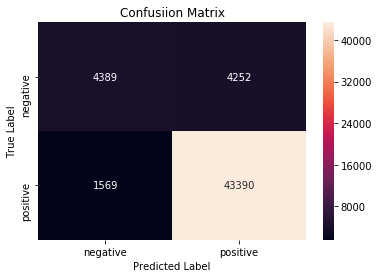

In [311]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF Model.
1. As we have seen on confusion matrix, we have 43390 + 4389 = 47779 correct prediction on training set.
2. Acccuracy of 47779 correct prediction on training set is 89.139%.

# Confusion Matrix For Test Set Of TFIDF Model

In [373]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, calibrated_clf.predict(X_test_tf_idf_standardized)))
cm

array([[  225,  2950],
       [  838, 15987]], dtype=int64)

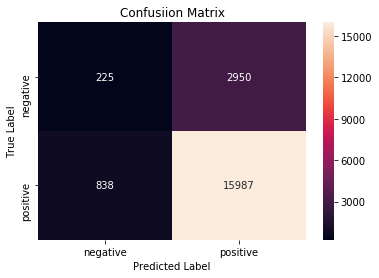

In [374]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF Model.
2. As we have seen on confusion matrix, we have 15987 + 225 = 16212 correct prediction on test set.
2. We have 16212 correct prediction on test set.

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

### Applying Linear SVM with L1 regularization on AVG W2V,<font color='red'> SET 3</font>

In [314]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
sent_vectors_train_standardized = sc.fit_transform(sent_vectors_train)
sent_vectors_cv_standardized = sc.fit_transform(sent_vectors_cv)
sent_vectors_test_standardized = sc.transform(sent_vectors_test)

In [315]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'alpha': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
param_grid = {'alpha': Alpha}

#Using GridSearchCV
model = GridSearchCV(SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(sent_vectors_cv_standardized, Y_cv))


optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8957160438563911
The optimal value of alpha is :  0.01


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

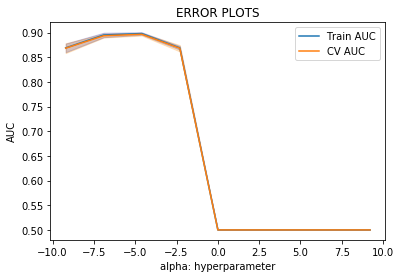

In [323]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in alpha:

    SGD = SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced", alpha = i)
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'alpha': Alpha}
    clf = GridSearchCV(SGD, param_grid, cv=5, scoring='roc_auc')
    clf.fit(sent_vectors_train_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(alpha), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(alpha), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

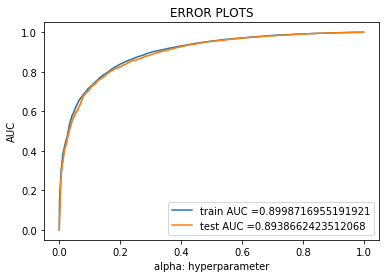

Train confusion matrix
[[ 3802  4839]
 [ 1545 43414]]
Test confusion matrix
[[ 1371  1804]
 [  589 16236]]
Test AUC is: 0.8938662423512068


In [324]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# https://github.com/scikit-learn/scikit-learn/issues/7278

SGD = SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced", alpha = 0.01) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
calibrated_clf = CalibratedClassifierCV(SGD, cv=5, method='sigmoid')
calibrated_clf.fit(sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, calibrated_clf.predict_proba(sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, calibrated_clf.predict_proba(sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, calibrated_clf.predict(sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, calibrated_clf.predict(sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
avg_w2v_L1_auc  = roc_auc_score(Y_test, calibrated_clf.predict_proba(sent_vectors_test_standardized)[:,1])
print("Test AUC is:", avg_w2v_L1_auc)

In [325]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== SGD with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

SGD_optimal = SGDClassifier(alpha=optimal_alpha)

# fitting the model
SGD_optimal.fit(sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = SGD_optimal.predict(sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Stochastic Gradient Descent classifier for alpha = %.4f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_L1_grid_C = optimal_alpha
avg_w2v_L1_grid_train_acc = model.score(sent_vectors_test_standardized, Y_test)*100
avg_w2v_L1_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 88.325000%


Observation(s):

1. The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 88.325000%.

# Confusion Matrix of Training Set Of w2v Model

In [326]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, calibrated_clf.predict(sent_vectors_train_standardized))
cm

array([[ 3802,  4839],
       [ 1545, 43414]], dtype=int64)

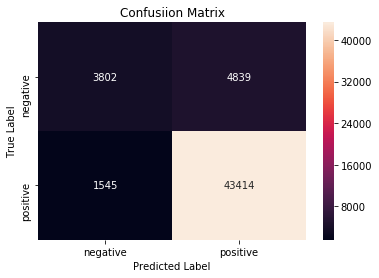

In [327]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of AVG W2V Model.
1. As we have seen on confusion matrix, we have 43414 + 3802 = 47216 correct prediction on training set.
2. Acccuracy of 47216 correct prediction on training set is 88.089%.

# Confusion Matrix For Test Set Of BOW Model

In [328]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, calibrated_clf.predict(sent_vectors_test_standardized))
cm

array([[ 1371,  1804],
       [  589, 16236]], dtype=int64)

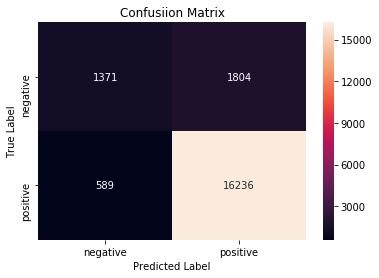

In [329]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of AVG W2V Model.
2. As we have seen on confusion matrix, we have 16236 + 1371 = 17607 correct prediction on test set.
2. We have 17625 correct prediction on test set.

### Applying Linear SVM with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [330]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'alpha': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
param_grid = {'alpha': Alpha}

#Using GridSearchCV
model = GridSearchCV(SGDClassifier(penalty='l2', loss = "hinge", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(sent_vectors_cv_standardized, Y_cv))


optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.9009945728125479
The optimal value of alpha is :  0.01


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

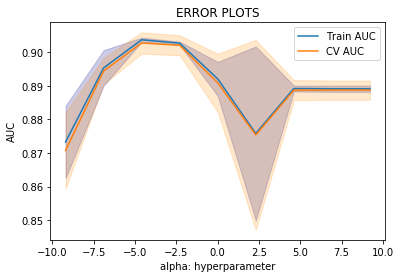

In [331]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in alpha:

    SGD = SGDClassifier(penalty='l2', loss = "hinge", class_weight = "balanced", alpha = i)
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'alpha': Alpha}
    clf = GridSearchCV(SGD, param_grid, cv=5, scoring='roc_auc')
    clf.fit(sent_vectors_train_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(alpha), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(alpha), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

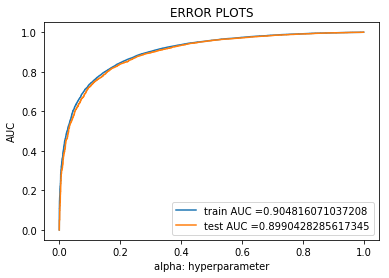

Train confusion matrix
[[ 3989  4652]
 [ 1549 43410]]
Test confusion matrix
[[ 1453  1722]
 [  593 16232]]
Test AUC is: 0.8990428285617345


In [332]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# https://github.com/scikit-learn/scikit-learn/issues/7278

SGD = SGDClassifier(penalty='l2', loss = "hinge", class_weight = "balanced", alpha = 0.01) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
calibrated_clf = CalibratedClassifierCV(SGD, cv=5, method='sigmoid')
calibrated_clf.fit(sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, calibrated_clf.predict_proba(sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, calibrated_clf.predict_proba(sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, calibrated_clf.predict(sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, calibrated_clf.predict(sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
avg_w2v_L2_auc  = roc_auc_score(Y_test, calibrated_clf.predict_proba(sent_vectors_test_standardized)[:,1])
print("Test AUC is:", avg_w2v_L2_auc)

In [333]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== SGD with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

SGD_optimal = SGDClassifier(alpha=optimal_alpha)

# fitting the model
SGD_optimal.fit(sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = SGD_optimal.predict(sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Stochastic Gradient Descent classifier for alpha = %.4f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v_L2_grid_C = optimal_alpha
avg_w2v_L2_grid_train_acc = model.score(sent_vectors_test_standardized, Y_test)*100
avg_w2v_L2_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 87.895000%


Observation(s):

1. The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 87.895000%.

# Confusion Matrix of Training Set Of W2V Model

In [334]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, calibrated_clf.predict(sent_vectors_train_standardized))
cm

array([[ 3989,  4652],
       [ 1549, 43410]], dtype=int64)

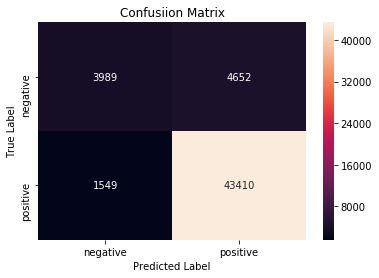

In [335]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of AVG W2V Model.
1. As we have seen on confusion matrix, we have 43410 + 3989 = 47399 correct prediction on training set.
2. Acccuracy of 47399 correct prediction on training set is 88.430%.

# Confusion Matrix For Test Set Of W2V Model

In [336]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, calibrated_clf.predict(sent_vectors_test_standardized)))
cm

array([[ 1453,  1722],
       [  593, 16232]], dtype=int64)

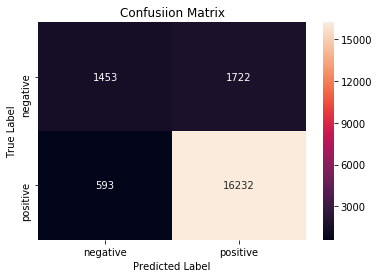

In [337]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of AVG W2V Model.
2. As we have seen on confusion matrix, we have 16232 + 1453 = 17685 correct prediction on test set.
2. We have 17685 correct prediction on test set.

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

### Applying Linear SVM with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [338]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
tfidf_sent_vectors_train_standardized = sc.fit_transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv_standardized = sc.fit_transform(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test_standardized = sc.transform(tfidf_sent_vectors_test)

In [339]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'alpha': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
param_grid = {'alpha': Alpha}

#Using GridSearchCV
model = GridSearchCV(SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(tfidf_sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tfidf_sent_vectors_cv_standardized, Y_cv))


optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l1', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8733617017543518
The optimal value of alpha is :  0.01


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

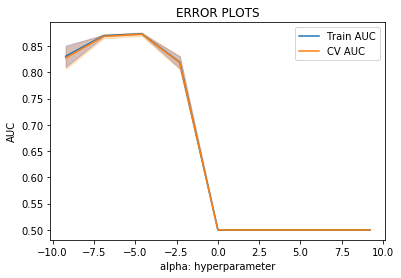

In [340]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in alpha:

    SGD = SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced", alpha = i)
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'alpha': Alpha}
    clf = GridSearchCV(SGD, param_grid, cv=5, scoring='roc_auc')
    clf.fit(tfidf_sent_vectors_train_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(alpha), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(alpha), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

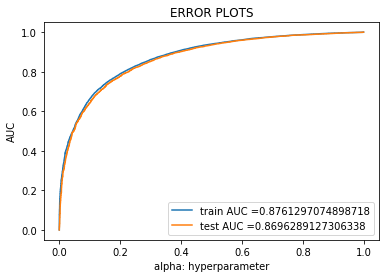

Train confusion matrix
[[ 3112  5529]
 [ 1372 43587]]
Test confusion matrix
[[ 1115  2060]
 [  539 16286]]
Test AUC is: 0.8696289127306338


In [341]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# https://github.com/scikit-learn/scikit-learn/issues/7278

SGD = SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced", alpha = 0.01) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
calibrated_clf = CalibratedClassifierCV(SGD, cv=5, method='sigmoid')
calibrated_clf.fit(tfidf_sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, calibrated_clf.predict_proba(tfidf_sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, calibrated_clf.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, calibrated_clf.predict(tfidf_sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, calibrated_clf.predict(tfidf_sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_w2v_L1_auc  = roc_auc_score(Y_test, calibrated_clf.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])
print("Test AUC is:", tfidf_w2v_L1_auc)

In [342]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== SGD with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

SGD_optimal = SGDClassifier(alpha=optimal_alpha)

# fitting the model
SGD_optimal.fit(tfidf_sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = SGD_optimal.predict(tfidf_sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Stochastic Gradient Descent classifier for alpha = %.4f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_L1_grid_C = optimal_alpha
tfidf_w2v_L1_grid_train_acc = model.score(tfidf_sent_vectors_test_standardized, Y_test)*100
tfidf_w2v_L1_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 86.545000%


Observation(s):

1. The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 86.545000%.

# Confusion Matrix of Training Set Of TFIDF W2V Model

In [343]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, calibrated_clf.predict(tfidf_sent_vectors_train_standardized))
cm

array([[ 3112,  5529],
       [ 1372, 43587]], dtype=int64)

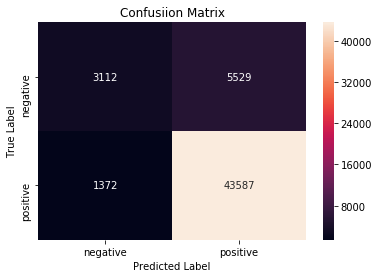

In [344]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF W2V Model.
1. As we have seen on confusion matrix, we have 43587 + 3112 = 46699 correct prediction on training set.
2. Acccuracy of 46854 correct prediction on training set is 87.125%.

# Confusion Matrix For Test Set Of TFIDF W2V Model

In [345]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, calibrated_clf.predict(tfidf_sent_vectors_test_standardized))
cm

array([[ 1115,  2060],
       [  539, 16286]], dtype=int64)

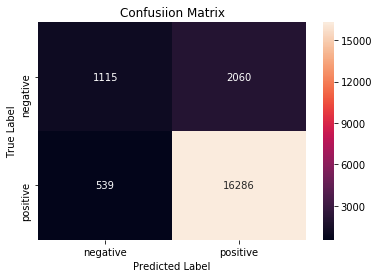

In [346]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF W2V Model.
2. As we have seen on confusion matrix, we have 16286 + 1115 = 17401 correct prediction on test set.
2. We have 17401 correct prediction on test set.

### Applying Linear SVM with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [347]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'alpha': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
param_grid = {'alpha': Alpha}

#Using GridSearchCV
model = GridSearchCV(SGDClassifier(penalty='l2', loss = "hinge", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(tfidf_sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tfidf_sent_vectors_cv_standardized, Y_cv))


optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.01, average=False, class_weight='balanced', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy of the model :  0.8792607899202891
The optimal value of alpha is :  0.01


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

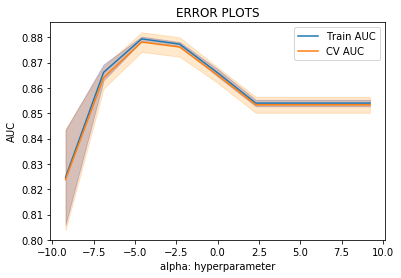

In [348]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV

train_auc = []
cv_auc = []
alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in alpha:

    SGD = SGDClassifier(penalty='l2', loss = "hinge", class_weight = "balanced", alpha = i)
    Alpha = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'alpha': Alpha}
    clf = GridSearchCV(SGD, param_grid, cv=5, scoring='roc_auc')
    clf.fit(tfidf_sent_vectors_train_standardized, Y_train)
    

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(alpha), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(alpha), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(alpha),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

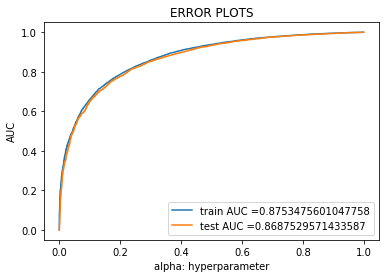

Train confusion matrix
[[ 3107  5534]
 [ 1424 43535]]
Test confusion matrix
[[ 1109  2066]
 [  556 16269]]
Test AUC is: 0.8687529571433587


In [349]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

# https://github.com/scikit-learn/scikit-learn/issues/7278

SGD = SGDClassifier(penalty='l1', loss = "hinge", class_weight = "balanced", alpha = 0.01) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
calibrated_clf = CalibratedClassifierCV(SGD, cv=5, method='sigmoid')
calibrated_clf.fit(tfidf_sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, calibrated_clf.predict_proba(tfidf_sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, calibrated_clf.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, calibrated_clf.predict(tfidf_sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, calibrated_clf.predict(tfidf_sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_w2v_L2_auc  = roc_auc_score(Y_test, calibrated_clf.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])
print("Test AUC is:", tfidf_w2v_L2_auc)

In [350]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== SGD with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

SGD_optimal = SGDClassifier(alpha=optimal_alpha)

# fitting the model
SGD_optimal.fit(tfidf_sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = SGD_optimal.predict(tfidf_sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Stochastic Gradient Descent classifier for alpha = %.4f is %f%%' % (optimal_alpha, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_L2_grid_C = optimal_alpha
tfidf_w2v_L2_grid_train_acc = model.score(tfidf_sent_vectors_test_standardized, Y_test)*100
tfidf_w2v_L2_grid_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 86.855000%


Observation(s):

1. The Test Accuracy of the Stochastic Gradient Descent classifier for alpha = 0.0100 is 86.855000%.

# Confusion Matrix of Training Set Of TFIDF W2V Model

In [351]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, calibrated_clf.predict(tfidf_sent_vectors_train_standardized))
cm

array([[ 3107,  5534],
       [ 1424, 43535]], dtype=int64)

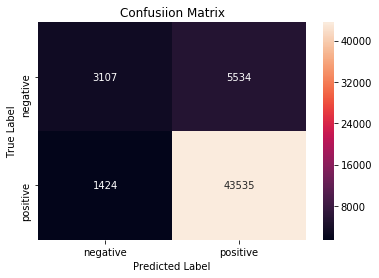

In [352]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF W2V Model.
1. As we have seen on confusion matrix, we have 43535 + 3107 = 46642 correct prediction on training set.
2. Acccuracy of 46642 correct prediction on training set is 87.018%.

# Confusion Matrix For Test Set Of TFIDF W2V Model

In [353]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, calibrated_clf.predict(tfidf_sent_vectors_test_standardized))
cm

array([[ 1109,  2066],
       [  556, 16269]], dtype=int64)

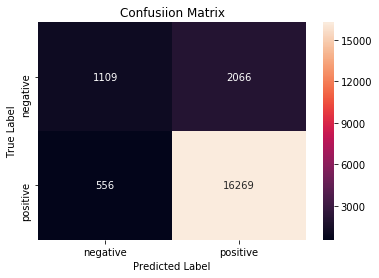

In [354]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF W2V Model.
2. As we have seen on confusion matrix, we have 16269 + 1109 = 17378 correct prediction on test set.
2. We have 17378 correct prediction on test set.

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_bow_standardized = sc.fit_transform(X_train_bow)
X_test_bow_standardized = sc.transform(X_test_bow)
X_cv_bow_standardized = sc.transform(X_cv_bow)

In [48]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'C': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
C_range = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]

param_grid = {'C': C_range}

#Using GridSearchCV
model = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_bow_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_bow_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C is : ",optimal_C)

Model with best parameters :
 SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of the model :  0.9922409708135035
The optimal value of C is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

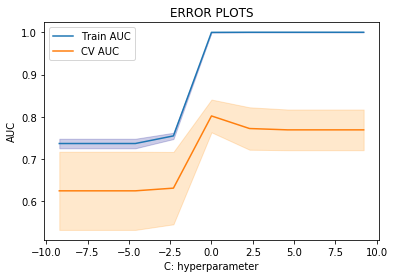

In [49]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in C:

    svc = SVC(kernel = "rbf", class_weight = "balanced", C = i)  # https://scikit-learn.org/stable/modules/svm.html
    C = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'C': C}
    clf = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_bow_standardized, Y_train)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

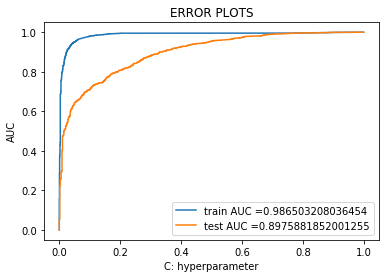

Train confusion matrix
[[1771   62]
 [ 676 8211]]
Test confusion matrix
[[ 455  215]
 [ 367 2963]]
Test AUC is: 0.8975881852001255


In [50]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


svc = SVC(kernel = "rbf", class_weight = "balanced", C = 1, probability = True) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
# Here we are taking  probability=True otherwise we are getting this error
#"AttributeError: predict_proba is not available when  probability=False
svc.fit(X_train_bow_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, svc.predict_proba(X_train_bow_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, svc.predict_proba(X_test_bow_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, svc.predict(X_train_bow_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, svc.predict(X_test_bow_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
rbf_bow_auc = roc_auc_score(Y_test, svc.predict_proba(X_test_bow_standardized)[:,1])
print("Test AUC is:", rbf_bow_auc)

In [100]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

SVC_optimal = SVC(C=optimal_C)

# fitting the model
SVC_optimal.fit(X_train_bow_standardized, Y_train)

# predict the response
Y_pred = SVC_optimal.predict(X_test_bow_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Support Vector classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
rbf_bow = optimal_C
rbf_bow_train_acc = model.score(X_test_bow_standardized, Y_test)*100
rbf_bow_test_acc = acc


The Test Accuracy of the Support Vector classifier for C = 1.000 is 84.825000%


Observation(s):
    
1. The Test Accuracy of the Support Vector classifier for C = 1.000 is 84.825000%.

# Confusion Matrix of Training Set Of BOW Model

In [52]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, svc.predict(X_train_bow_standardized))
cm

array([[1771,   62],
       [ 676, 8211]], dtype=int64)

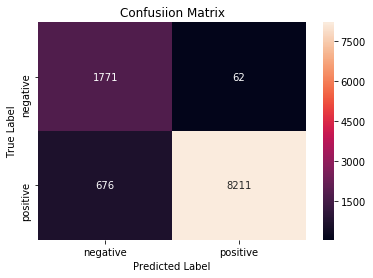

In [53]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of BOW Model.
1. As we have seen on confusion matrix, we have 8211 + 1771 = 9982 correct prediction on training set.
2. Acccuracy of 9982 correct prediction on training set is 99.115%.

# Confusion Matrix For Test Set Of BOW Model

In [54]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, svc.predict(X_test_bow_standardized)))
cm

array([[ 455,  215],
       [ 367, 2963]], dtype=int64)

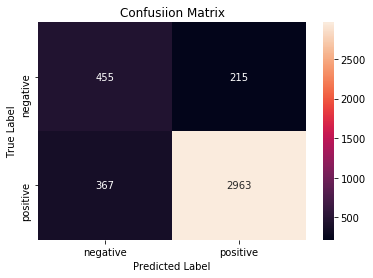

In [55]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of BOW Model.
2. As we have seen on confusion matrix, we have 2963 + 455 = 3418 correct prediction on test set.
2. Acccuracy of 3418 correct prediction on test set is 84.82%.

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [97]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
X_train_tf_idf_standardized = sc.fit_transform(X_train_tf_idf)
X_cv_tf_idf_standardized = sc.fit_transform(X_cv_tf_idf)
X_test_tf_idf_standardized = sc.transform(X_test_tf_idf)

# GridSearchCV Implementation

In [98]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'C': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
C_range = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]

param_grid = {'C': C_range}

#Using GridSearchCV
model = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(X_cv_tf_idf_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_cv_tf_idf_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C is : ",optimal_C)

Model with best parameters :
 SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of the model :  0.9987836257309942
The optimal value of C is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

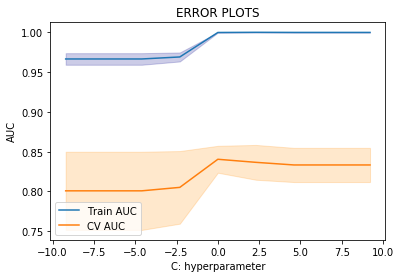

In [84]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in C:

    svc = SVC(kernel = "rbf", class_weight = "balanced", C = i)  # https://scikit-learn.org/stable/modules/svm.html
    C = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'C': C}
    clf = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')
    clf.fit(X_train_tf_idf_standardized, Y_train)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

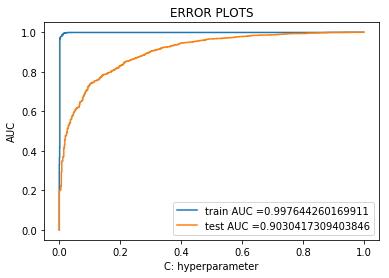

Train confusion matrix
[[1716    5]
 [ 259 8740]]
Test confusion matrix
[[ 396  211]
 [ 255 3138]]
Test AUC is: 0.5024180027588537


In [99]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


svc = SVC(kernel = "rbf", class_weight = "balanced", C = 1, probability = True) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
# Here we are taking  probability=True otherwise we are getting this error
#"AttributeError: predict_proba is not available when  probability=False
svc.fit(X_train_tf_idf_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, svc.predict_proba(X_train_tf_idf_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, svc.predict_proba(X_test_tf_idf_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, svc.predict(X_train_tf_idf_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, svc.predict(X_test_tf_idf_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
rbf_tfidf_auc = roc_auc_score(Y_test, svc.predict_proba(X_test_bow_standardized)[:,1])
print("Test AUC is:", rbf_tfidf_auc)

In [101]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

SVC_optimal = SVC(C=optimal_C)

# fitting the model
SVC_optimal.fit(X_train_tf_idf_standardized, Y_train)

# predict the response
Y_pred = SVC_optimal.predict(X_test_tf_idf_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Support Vector classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
rbf_tfidf = optimal_C
rbf_tfidf_train_acc = model.score(X_test_tf_idf_standardized, Y_test)*100
rbf_tfidf_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Support Vector classifier for C = 1.000 is 88.500000%


Observation(s):

1. The Test Accuracy of the Support Vector classifier for C = 1.000 is 88.500000%.

# Confusion Matrix of Training Set Of TFIDF Model

In [102]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_train, svc.predict(X_train_tf_idf_standardized)))
cm

array([[1716,    5],
       [ 259, 8740]], dtype=int64)

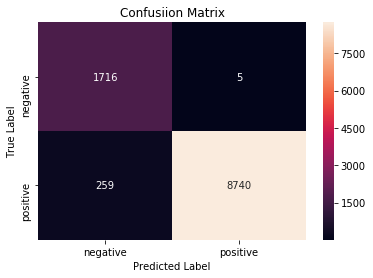

In [103]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF Model.
1. As we have seen on confusion matrix, we have 8740 + 1716 = 10456 correct prediction on training set.
2. Acccuracy of 10456 correct prediction on training set is 97.53%.

# Confusion Matrix of Test Set Of TFIDF Model

In [105]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = (confusion_matrix(Y_test, svc.predict(X_test_tf_idf_standardized)))
cm

array([[ 396,  211],
       [ 255, 3138]], dtype=int64)

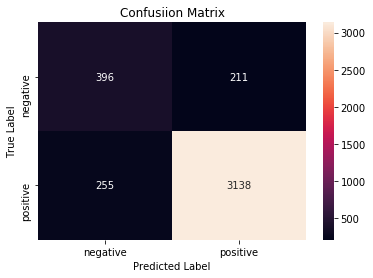

In [106]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF Model.
2. As we have seen on confusion matrix, we have 3138 + 396 = 3534 correct prediction on test set.
2. Acccuracy of 3534 correct prediction on test set is 88.50%.

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [149]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
sent_vectors_train_standardized = sc.fit_transform(sent_vectors_train)
sent_vectors_cv_standardized = sc.fit_transform(sent_vectors_cv)
sent_vectors_test_standardized = sc.transform(sent_vectors_test)

In [152]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'C': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
C_range = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]

param_grid = {'C': C_range}

#Using GridSearchCV
model = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(sent_vectors_cv_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C is : ",optimal_C)

Model with best parameters :
 SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of the model :  0.9049106553753019
The optimal value of C is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

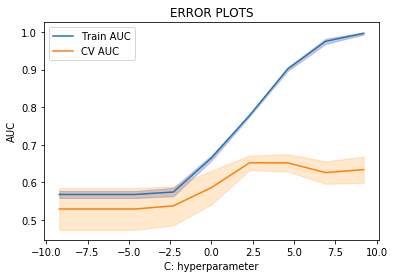

In [129]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in C:

    svc = SVC(kernel = "rbf", class_weight = "balanced", C = i)  # https://scikit-learn.org/stable/modules/svm.html
    C = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'C': C}
    clf = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')
    clf.fit(sent_vectors_train_standardized, Y_train)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

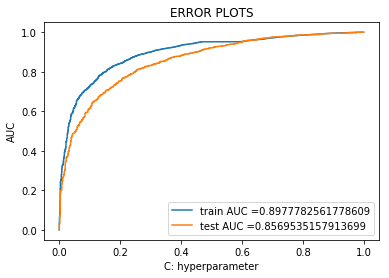

Train confusion matrix
[[1470  216]
 [2065 6969]]
Test confusion matrix
[[ 464  153]
 [ 680 2703]]
Test AUC is: 0.8569535157913699


In [155]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


svc = SVC(kernel = "rbf", class_weight = "balanced", C = 1, probability = True) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
# Here we are taking  probability=True otherwise we are getting this error
#"AttributeError: predict_proba is not available when  probability=False
svc.fit(sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, svc.predict_proba(sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, svc.predict_proba(sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, svc.predict(sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, svc.predict(sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
avg_w2v_auc = roc_auc_score(Y_test, svc.predict_proba(sent_vectors_test_standardized)[:,1])
print("Test AUC is:", avg_w2v_auc)

In [156]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

avg_w2v_optimal = SVC(C=optimal_C)

# fitting the model
avg_w2v_optimal.fit(sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = avg_w2v_optimal.predict(sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Support Vector classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
avg_w2v = optimal_C
avg_w2v_train_acc = model.score(sent_vectors_test_standardized, Y_test)*100
avg_w2v_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Support Vector classifier for C = 1.000 is 85.325000%


Observation(s):

1. The Test Accuracy of the Support Vector classifier for C = 1.000 is 85.325000%.

# Confusion Matrix of Training Set Of w2v Model

In [157]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, svc.predict(sent_vectors_train_standardized))
cm

array([[1470,  216],
       [2065, 6969]], dtype=int64)

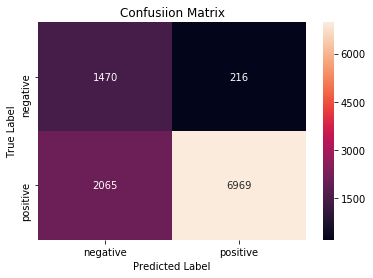

In [158]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of AVG W2V Model.
1. As we have seen on confusion matrix, we have 6969 + 1470 = 8439 correct prediction on training set.
2. Acccuracy of 8439 correct prediction on training set is 78.72%.

# Confusion Matrix For Test Set Of w2v Model

In [160]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, svc.predict(sent_vectors_test_standardized))
cm

array([[ 464,  153],
       [ 680, 2703]], dtype=int64)

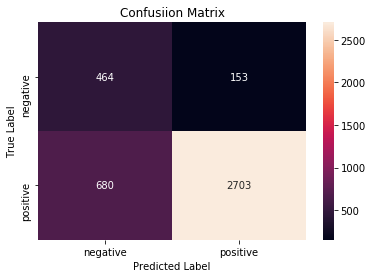

In [161]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of AVG W2V Model.
2. As we have seen on confusion matrix, we have 2703 + 464 = 3167 correct prediction on test set.
2. Acccuracy of 3167 correct prediction on test set is 85.32%.

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [228]:
# Data-preprocessing: Standardizing the data
sc = StandardScaler(with_mean=False)
tfidf_sent_vectors_train_standardized = sc.fit_transform(tfidf_sent_vectors_train)
tfidf_sent_vectors_cv_standardized = sc.fit_transform(tfidf_sent_vectors_cv)
tfidf_sent_vectors_test_standardized = sc.transform(tfidf_sent_vectors_test)

In [229]:
#code source: http://occam.olin.edu/sites/default/files/DataScienceMaterials/machine_learning_lecture_2/Machine%20Learning%20Lecture%202.html
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import *
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import cross_val_score

# tuned_parameters = [{'C': [[10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]]}]
# or we can wright it as
C_range = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]

param_grid = {'C': C_range}

#Using GridSearchCV
model = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid, scoring = 'roc_auc', cv=5 ,n_jobs=-1, 
                     pre_dispatch=2)
model.fit(tfidf_sent_vectors_cv_standardized, Y_cv)

print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(tfidf_sent_vectors_cv_standardized, Y_cv))


optimal_C = model.best_estimator_.C
print("The optimal value of C is : ",optimal_C)

Model with best parameters :
 SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy of the model :  0.907031948987346
The optimal value of C is :  1


# Hyper parameter Tuning

# Performance of Model for each Hyperparameter

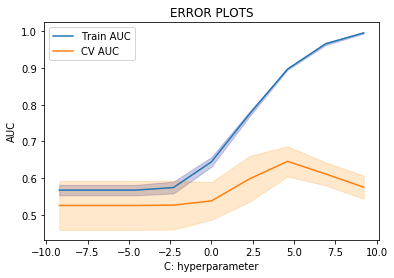

In [198]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

train_auc = []
cv_auc = []
C = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
for i in C:

    svc = SVC(kernel = "rbf", class_weight = "balanced", C = i)  # https://scikit-learn.org/stable/modules/svm.html
    C = [10**-4,10**-3,10**-2,10**-1,1,10**1,10**2,10**3,10**4]
    param_grid = {'C': C}
    clf = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc')
    clf.fit(tfidf_sent_vectors_train_standardized, Y_train)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score']
    cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(np.log(C), train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(np.log(C), cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(np.log(C),cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

# Testing with Test data

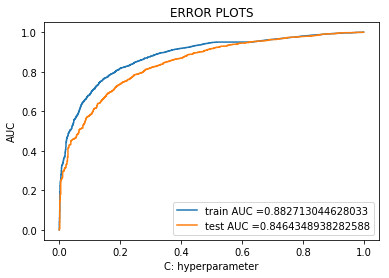

Train confusion matrix
[[1454  230]
 [2246 6790]]
Test confusion matrix
[[ 482  151]
 [ 769 2598]]
Test AUC is: 0.5109779849116343


In [239]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


svc = SVC(kernel = "rbf", class_weight = "balanced", C = 1, probability = True) # Here in plce of n_neighbors=19 we can also take n_neighbors=optimal_k. optimal_k will 
                                           # automatically take value which we have been observed when we have done 
                                           # k-fold cross validation
# Here we are taking  probability=True otherwise we are getting this error
#"AttributeError: predict_proba is not available when  probability=False
svc.fit(tfidf_sent_vectors_train_standardized, Y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(Y_train, svc.predict_proba(tfidf_sent_vectors_train_standardized)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, svc.predict_proba(tfidf_sent_vectors_test_standardized)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(Y_train, svc.predict(tfidf_sent_vectors_train_standardized)))
print("Test confusion matrix")
print(confusion_matrix(Y_test, svc.predict(tfidf_sent_vectors_test_standardized)))

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci
# AUC
#Area under ROC curve
tfidf_w2v_auc = roc_auc_score(Y_test, svc.predict_proba(sent_vectors_test_standardized)[:,1])
print("Test AUC is:", tfidf_w2v_auc)

In [240]:
# http://localhost:8888/notebooks/Downloads/kfold.ipynb
# ============================== lr with k = optimal_k ===============================================
# instantiate learning model k = optimal_k

tfidf_w2v_optimal = SVC(C=optimal_C)

# fitting the model
tfidf_w2v_optimal.fit(sent_vectors_train_standardized, Y_train)

# predict the response
Y_pred = tfidf_w2v_optimal.predict(sent_vectors_test_standardized)

# Accuracy on test data
acc = accuracy_score(Y_test, Y_pred) * 100
print('\nThe Test Accuracy of the Support Vector classifier for C = %.3f is %f%%' % (optimal_C, acc))

# Variables that will be used for  making table in Conclusion part of this assignment
tfidf_w2v_w2v = optimal_C
tfidf_w2v_w2v_train_acc = model.score(sent_vectors_test_standardized, Y_test)*100
tfidf_w2v_w2v_test_acc = accuracy_score(Y_test, Y_pred) * 100


The Test Accuracy of the Support Vector classifier for C = 1.000 is 84.175000%


Observation(s):

1. The Test Accuracy of the Support Vector classifier for C = 1.000 is 84.175000%.

# Confusion Matrix of Training Set Of TFIDF W2V Model

In [241]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_train, svc.predict(tfidf_sent_vectors_train_standardized))
cm

array([[1454,  230],
       [2246, 6790]], dtype=int64)

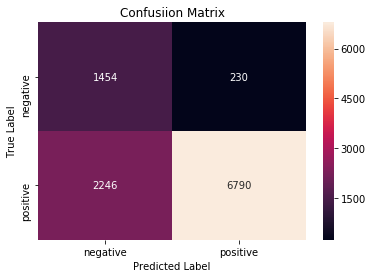

In [242]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Training Set Of TFIDF W2V Model.
1. As we have seen on confusion matrix, we have 6790 + 1454 = 6790 correct prediction on training set.
2. Acccuracy of 6790 correct prediction on training set is 76.90%.

# Confusion Matrix For Test Set Of TFIDF W2V Model

In [243]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, svc.predict(tfidf_sent_vectors_test_standardized))
cm

array([[ 482,  151],
       [ 769, 2598]], dtype=int64)

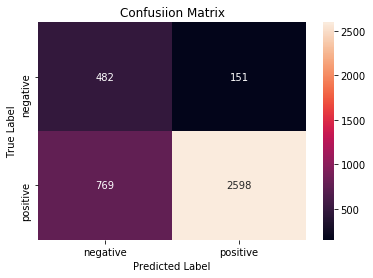

In [244]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Observation(s):

1. Here is a confusion matrix of Test Set Of TFIDF W2V Model.
2. As we have seen on confusion matrix, we have 2598 + 482 = 3080 correct prediction on test set.
2. Acccuracy of 3080 correct prediction on test set is 77.67%.

# [6] Conclusions

# Observation table for Linear SVM

In [355]:
# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['L1 Regularization of SGD in GridSearchCV for BoW','L2 Regularization of SGD in GridSearchCV for BoW', \
         'L1 Regularization of SGD in GridSearchCV for TFIDF','L2 Regularization of SGD in GridSearchCV for TFIDF', \
         'L1 Regularization of SGD in GridSearchCV for Avg_Word2Vec','L2 Regularization of SGD in GridSearchCV for Avg_Word2Vec', \
         'L1 Regularization of SGD in GridSearchCV for TFIDF_Word2Vec','L2 Regularization of SGD in GridSearchCV for TFIDF_Word2Vec']

# Optimal values of alpha 
optimal_alpha = [bow_L1_grid_C, bow_L2_grid_C, tfidf_L1_grid_C, tfidf_L2_grid_C, \
             avg_w2v_L1_grid_C, avg_w2v_L2_grid_C, tfidf_w2v_L1_grid_C, tfidf_w2v_L2_grid_C]

AUC = [bow_L1_auc, bow_L2_auc, tfidf_L1_auc, tfidf_L2_auc, avg_w2v_L1_auc, \
       avg_w2v_L2_auc, tfidf_w2v_L1_auc, tfidf_w2v_L2_auc]

test_acc = [bow_L1_grid_test_acc, bow_L2_grid_test_acc, tfidf_L1_grid_test_acc, tfidf_L2_grid_test_acc, \
            avg_w2v_L1_grid_test_acc,avg_w2v_L2_grid_test_acc,tfidf_w2v_L1_grid_test_acc, \
            tfidf_w2v_L2_grid_test_acc]

numbering = [1,2,3,4,5,6,7,8]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best alpha",optimal_alpha)
#ptable.add_column("Best C(1/lambda)",optimal_C)
ptable.add_column("AUC",AUC)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-------------------------------------------------------------+------------+--------------------+---------------+
| S.NO. |                            MODEL                            | Best alpha |        AUC         | Test Accuracy |
+-------+-------------------------------------------------------------+------------+--------------------+---------------+
|   1   |       L1 Regularization of SGD in GridSearchCV for BoW      |   0.0001   | 0.8859545062067836 |     86.18     |
|   2   |       L2 Regularization of SGD in GridSearchCV for BoW      |    0.1     | 0.8992574885048731 |     88.81     |
|   3   |      L1 Regularization of SGD in GridSearchCV for TFIDF     |    0.01    | 0.9006814100689123 |     88.845    |
|   4   |      L2 Regularization of SGD in GridSearchCV for TFIDF     |    0.1     | 0.9031191585450035 |     87.79     |
|   5   |  L1 Regularization of SGD in GridSearchCV for Avg_Word2Vec  |    0.01    | 0.8938662423512068 |     88.325    |
|   6   |  L2 Regulariza

# Observation table for RBF SVM

In [357]:
rbf_bow_auc
rbf_bow = optimal_C
rbf_bow_test_acc = acc



# Creating table using PrettyTable library
from prettytable import PrettyTable

# Names of models
names = ['Support Vector Machine in GridSearchCV for BoW', 'Support Vector Machine in GridSearchCV for TFIDF', \
         'Support Vector Machine in GridSearchCV for Avg_Word2Vec','Support Vector Machine in GridSearchCV for TFIDF_Word2Vec']

# Optimal values of C
optimal_C = [rbf_bow, rbf_tfidf, avg_w2v, tfidf_w2v_w2v]

AUC = [rbf_bow_auc, rbf_tfidf_auc, avg_w2v_auc, tfidf_w2v_auc]

test_acc = [rbf_bow_test_acc, rbf_tfidf_test_acc, avg_w2v_test_acc, tfidf_w2v_w2v_test_acc]

numbering = [1,2,3,4]

# Initializing prettytable
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Best C",optimal_C)
ptable.add_column("AUC",AUC)
ptable.add_column("Test Accuracy",test_acc)

# Printing the Table
print(ptable)

+-------+-----------------------------------------------------------+--------+--------------------+-------------------+
| S.NO. |                           MODEL                           | Best C |        AUC         |   Test Accuracy   |
+-------+-----------------------------------------------------------+--------+--------------------+-------------------+
|   1   |       Support Vector Machine in GridSearchCV for BoW      |   1    |         1          |       86.855      |
|   2   |      Support Vector Machine in GridSearchCV for TFIDF     |   1    | 0.5024180027588537 |        88.5       |
|   3   |  Support Vector Machine in GridSearchCV for Avg_Word2Vec  |   1    | 0.8569535157913699 | 85.32499999999999 |
|   4   | Support Vector Machine in GridSearchCV for TFIDF_Word2Vec |   1    | 0.5109779849116343 |       84.175      |
+-------+-----------------------------------------------------------+--------+--------------------+-------------------+


# Procedure Followed:

STEP 1 : Loading The Data
    
STEP 2 : Data Cleaning: Deduplication

STEP 3 : Preprocessing Review Text

STEP 4 : Preprocessing Review Summary

STEP 5 : Time-based splitting of whole dataset into X_train, Y_train, X_test, Y_test, X_cv and Y_cv.

STEP 6 : Applying Featurization Technique to convert text into vector.(i.e. BAG OF WORDS Model)

STEP 7 : Standardizing the data

STEP 8 : Applying Linear SVM on BOW

STEP 9 : Using SGDClassifier with hinge-loss as an estimator in GridSearchCV in order to find optimal value of alpha with 
         both L1 and L2 regularisation

STEP 10 : Plotting the performance of model both on train data and cross validation data for each hyper parameter

STEP 11 : Finding the AUC on test data and plotting the ROC curve on both train and test.

STEP 12 : Drawing the confusion matrix using Seaborn Heatmaps.

STEP 13 : Finding the top 10 features of positive class from Set 1. (Only in Bow Vectorizer)

STEP 14 : Finding top 10 features of negative class from Set 1.(Only in Bow Vectorizer)

STEP 15 : Repeat STEP 6 to STEP 14 for TFIDF, Avg_w2v, TFIDF_w2v Vectorizer.

STEP 16 : Applying RBF SVM on BOW

STEP 17 : Using SVCClassifier as an estimator in GridSearchCV in order to find optimal value of C.

STEP 18 : Plotting the performance of model both on train data and cross validation data for each hyper parameter

STEP 19 : Finding the AUC on test data and plotting the ROC curve on both train and test.

STEP 20 : Drawing the confusion matrix using Seaborn Heatmaps.

STEP 21 : Repeat STEP 16 to STEP 20 for TFIDF, Avg_w2v, TFIDF_w2v Vectorizer.
